<a href="https://colab.research.google.com/github/jayash1973/projects/blob/main/FLAME_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c 2024-flame-ai-challenge
!unzip 2024-flame-ai-challenge.zip

 34% 11.0M/32.0M [00:00<00:01, 11.6MB/s]
100% 32.0M/32.0M [00:01<00:00, 32.0MB/s]
Archive:  2024-flame-ai-challenge.zip
  inflating: dataset/test.csv        
  inflating: dataset/test/theta_K_id098830.dat  
  inflating: dataset/test/theta_K_id167403.dat  
  inflating: dataset/test/theta_K_id203229.dat  
  inflating: dataset/test/theta_K_id219547.dat  
  inflating: dataset/test/theta_K_id225258.dat  
  inflating: dataset/test/theta_K_id274499.dat  
  inflating: dataset/test/theta_K_id294850.dat  
  inflating: dataset/test/theta_K_id298026.dat  
  inflating: dataset/test/theta_K_id329500.dat  
  inflating: dataset/test/theta_K_id352206.dat  
  inflating: dataset/test/theta_K_id424039.dat  
  inflating: dataset/test/theta_K_id425723.dat  
  inflating: dataset/test/theta_K_id498251.dat  
  inflating: dataset/test/theta_K_id571295.dat  
  inflating: dataset/test/theta_K_id652614.dat  
  inflating: dataset/test/theta_K_id714528.dat  
  inflating: dataset/test/theta_K_id757503.dat  
  inflati

In [ ]:
%%capture
!pip install fvcore lightning einops tensorboard timm openstl PyWavelets

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader, Sampler
import random

In [ ]:
INPUT_PATH = '/content/dataset'
PRE_SEQ_LENGTH = 6
AFT_SEQ_LENGTH = 20
BATCH_SIZE = 8

In [ ]:
def load_data(file_path):
    return pd.read_csv(file_path)

In [ ]:
def load_dat_file(filename, shape):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File not found: {filename}")
    try:
        data = np.fromfile(filename, dtype="<f4")
        if data.size != np.prod(shape):
            raise ValueError(f"File {filename} has {data.size} elements, expected {np.prod(shape)}")
        return data.reshape(shape)
    except Exception as e:
        print(f"Error loading file {filename}: {str(e)}")
        raise

In [ ]:
def preprocess_data(df, is_train=True):
    X = []
    dir_path = os.path.join(INPUT_PATH, 'train' if is_train else 'test')

    for _, row in tqdm(df.iterrows(), total=len(df)):
        nt, Nx, Ny = row['Nt'], row['Nx'], row['Ny']
        theta = load_dat_file(os.path.join(dir_path, row['theta_filename']), (nt, Nx, Ny))
        xi_f = load_dat_file(os.path.join(dir_path, row['xi_filename']), (nt, Nx, Ny))
        uin = np.full_like(theta, row['u'])
        alpha = np.full_like(theta, row['alpha'])

        X.append(np.stack([xi_f, theta/1000, uin/50, alpha/50], axis=-1))

    X = np.array(X).transpose(0, 1, 4, 2, 3)
    X = np.pad(X, pad_width=((0, 0), (0, 0), (0, 0), (0, 3), (0, 0)), mode='edge')

    if is_train:
        y = X[:, PRE_SEQ_LENGTH:]
        X = X[:, :-PRE_SEQ_LENGTH]
        return X, y
    else:
        X_ = np.zeros((len(df), PRE_SEQ_LENGTH, 4, 116, 32))
        X_[:, 1:, ...] = X[:, ...]
        X_[:, 0, ...] = X[:, 1, ...]
        return X_

In [ ]:
def temporal_slicing(X, y, step=1):
    num_simulations, time_steps, height, width, features = X.shape
    num_windows = time_steps - AFT_SEQ_LENGTH + 1
    X_sliced, y_sliced = [], []

    for sim in range(num_simulations):
        for start in range(0, num_windows, step):
            X_sliced.append(X[sim, start:start+PRE_SEQ_LENGTH, ...])
            y_sliced.append(y[sim, start:start+AFT_SEQ_LENGTH, ...])

    return np.array(X_sliced), np.array(y_sliced)

In [ ]:
def visualize_data(X, y=None, num_samples=3):
    for i in range(num_samples):
        for j in range(PRE_SEQ_LENGTH):
            plt.figure(figsize=(5, 5))
            plt.imshow(X[i, j, 0, :113, :].T)
            plt.axis('off')
            plt.title(f'Sample {i+1}, Input Time {j+1}')
            plt.show()

    if y is not None:
        for i in range(num_samples):
            for j in range(AFT_SEQ_LENGTH):
                plt.figure(figsize=(5, 5))
                plt.imshow(y[i, j, 0, :113, :].T)
                plt.axis('off')
                plt.title(f'Sample {i+1}, Output Time {j+1}')
                plt.show()

In [ ]:
class FireDataset(Dataset):
    def __init__(self, X, Y=None):
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        if self.Y is not None:
            labels = torch.tensor(self.Y[index]).float()
            return data, labels
        return data

In [ ]:
class CustomSampler(Sampler):
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size
        self.num_samples = len(data_source)

    def __iter__(self):
        indices = list(range(self.num_samples))
        random.shuffle(indices)
        batches = [indices[i:i + self.batch_size] for i in range(0, self.num_samples, self.batch_size)]
        random.shuffle(batches)
        return iter([item for batch in batches for item in batch])

    def __len__(self):
        return self.num_samples

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

In [ ]:
class EncoderDecoderConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers):
        super(EncoderDecoderConvLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers

        # Encoder (multiple ConvLSTM layers)
        self.encoder_cells = nn.ModuleList([ConvLSTMCell(input_dim if i == 0 else hidden_dim,
                                                         hidden_dim, kernel_size, True)
                                            for i in range(num_layers)])

        # Decoder (multiple ConvLSTM layers)
        self.decoder_cells = nn.ModuleList([ConvLSTMCell(hidden_dim, hidden_dim, kernel_size, True)
                                            for _ in range(num_layers)])

        # Output convolution
        self.output_conv = nn.Conv2d(hidden_dim, 4, kernel_size=1)  # Changed output channels to 4

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.size()

        # Initialize hidden states
        h_t, c_t = self.init_hidden(batch_size, height, width, x.device)

        # Encoding
        for t in range(seq_len):
            x_t = x[:, t, :, :, :]
            for i, cell in enumerate(self.encoder_cells):
                h_t[i], c_t[i] = cell(x_t if i == 0 else h_t[i-1], (h_t[i], c_t[i]))

        # Decoding
        outputs = []
        for _ in range(20):  # Predict 20 timesteps
            for i, cell in enumerate(self.decoder_cells):
                h_t[i], c_t[i] = cell(h_t[i-1] if i > 0 else h_t[-1], (h_t[i], c_t[i]))
            output = self.output_conv(h_t[-1])
            outputs.append(output)

        return torch.stack(outputs, dim=1)

    def init_hidden(self, batch_size, height, width, device):
        h = [torch.zeros(batch_size, self.hidden_dim, height, width, device=device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_dim, height, width, device=device) for _ in range(self.num_layers)]
        return h, c

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, accumulation_steps=4):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        optimizer.zero_grad()  # Zero gradients at the beginning of each epoch

        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            try:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss = loss / accumulation_steps  # Normalize the loss
                loss.backward()

                if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                    optimizer.step()
                    optimizer.zero_grad()

                train_loss += loss.item() * accumulation_steps

                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"Warning: Loss is {loss} at batch {batch_idx}")

            except Exception as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                print(f"Input shape: {inputs.shape}")
                print(f"Target shape: {targets.shape}")
                continue  # Skip this batch and continue with the next one

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                try:
                    inputs, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                except Exception as e:
                    print(f"Error in validation: {str(e)}")
                    print(f"Input shape: {inputs.shape}")
                    continue  # Skip this batch and continue with the next one

        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

    return model

In [ ]:
print("Loading and preprocessing data...")
train_df = load_data(os.path.join(INPUT_PATH, 'train.csv'))
test_df = load_data(os.path.join(INPUT_PATH, 'test.csv'))

Loading and preprocessing data...


In [ ]:
X, y = preprocess_data(train_df)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
print("Sliced X_train shape:", X_train.shape)
print("Sliced y_train shape:", y_train.shape)
print("Sliced X_val shape:", X_val.shape)
print("Sliced y_val shape:", y_val.shape)

Sliced X_train shape: (7, 144, 4, 116, 32)
Sliced y_train shape: (7, 144, 4, 116, 32)
Sliced X_val shape: (2, 144, 4, 116, 32)
Sliced y_val shape: (2, 144, 4, 116, 32)


In [ ]:
X_train_sliced, y_train_sliced = temporal_slicing(X_train, y_train)
X_val_sliced, y_val_sliced = temporal_slicing(X_val, y_val)

In [ ]:
print("Sliced X_train shape:", X_train_sliced.shape)
print("Sliced y_train shape:", y_train_sliced.shape)
print("Sliced X_val shape:", X_val_sliced.shape)
print("Sliced y_val shape:", y_val_sliced.shape)

Sliced X_train shape: (875, 6, 4, 116, 32)
Sliced y_train shape: (875, 20, 4, 116, 32)
Sliced X_val shape: (250, 6, 4, 116, 32)
Sliced y_val shape: (250, 20, 4, 116, 32)


Visualizing training data...


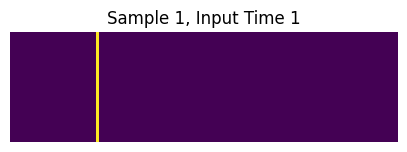

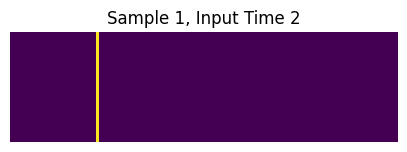

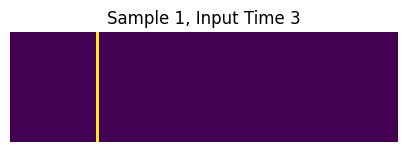

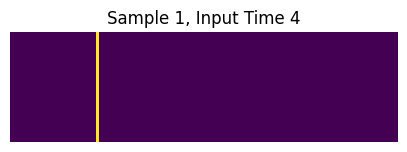

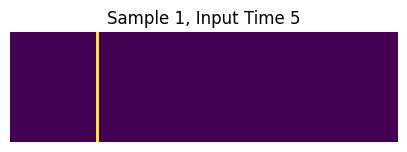

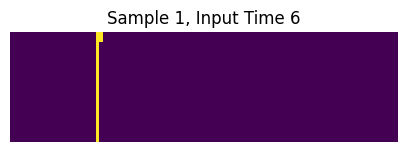

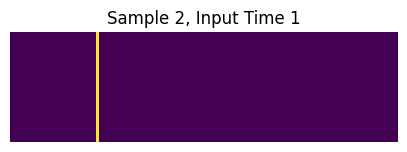

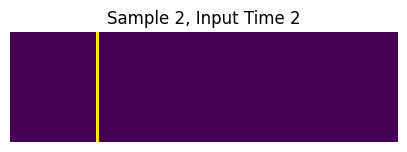

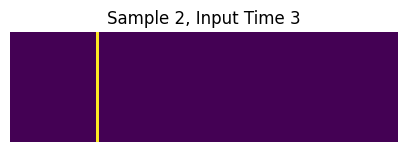

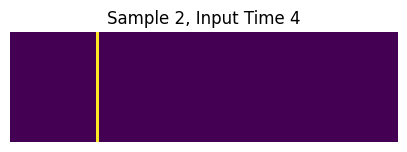

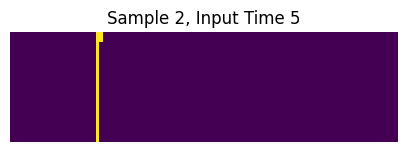

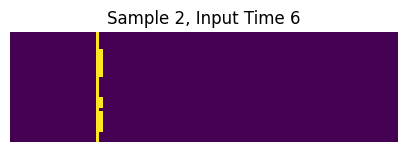

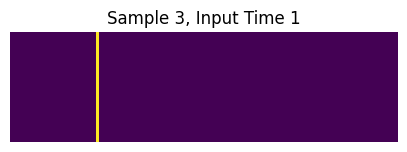

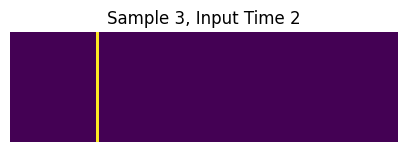

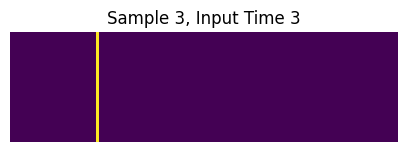

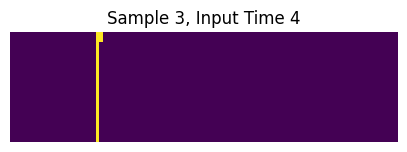

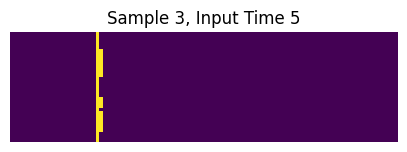

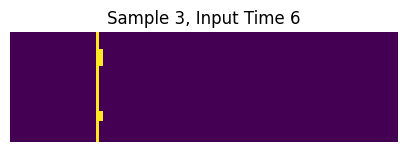

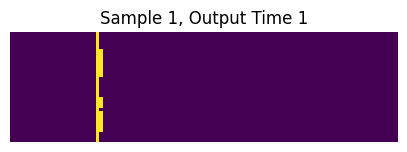

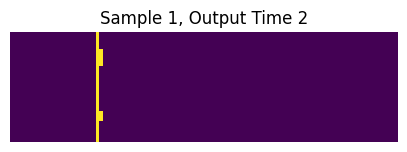

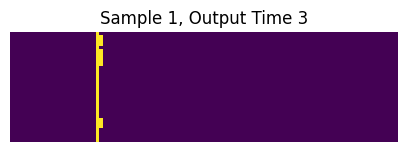

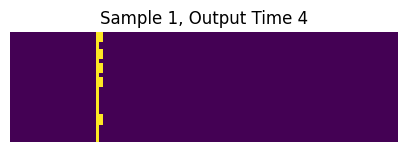

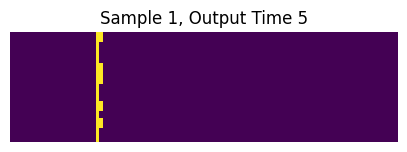

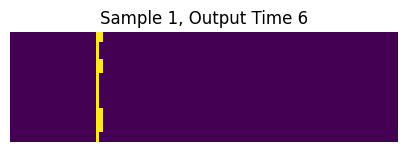

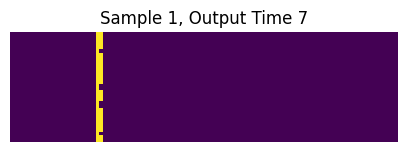

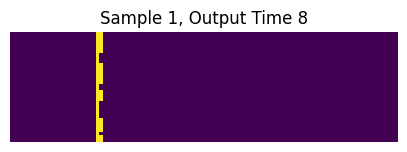

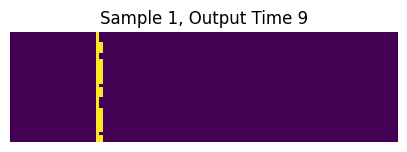

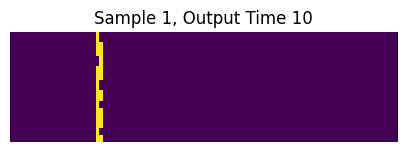

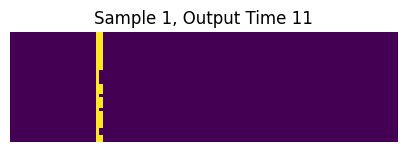

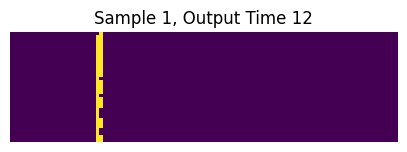

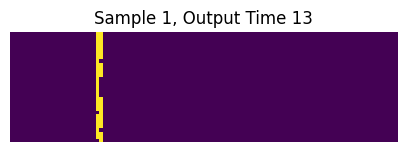

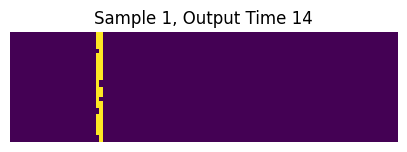

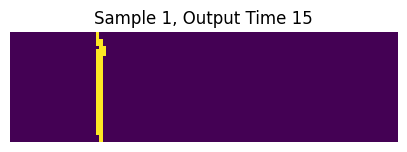

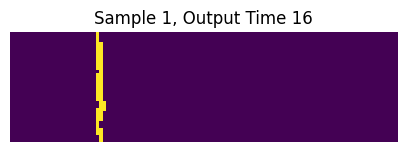

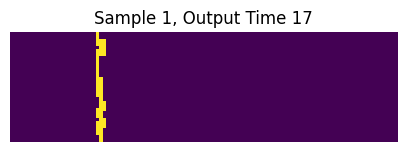

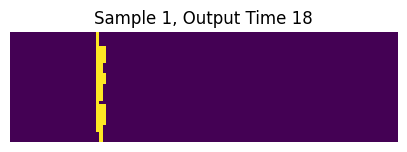

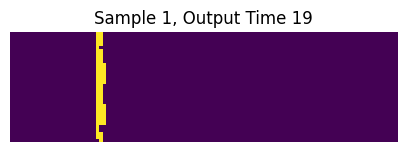

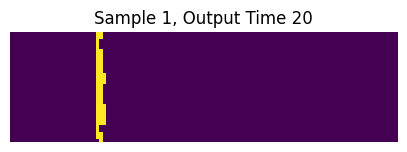

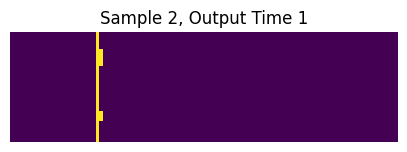

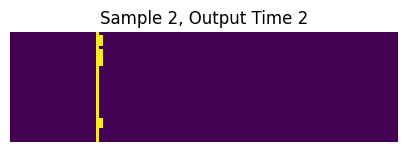

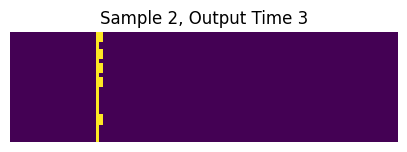

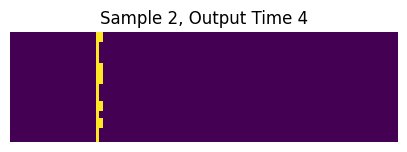

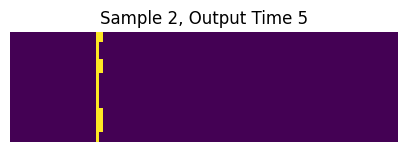

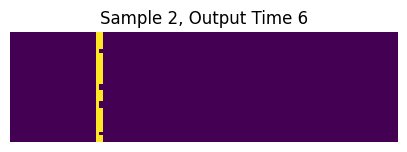

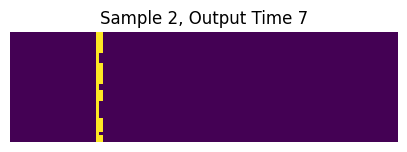

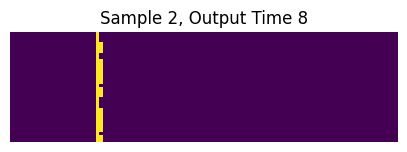

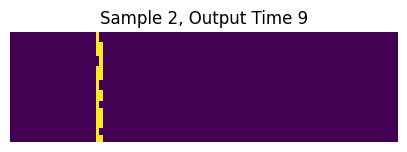

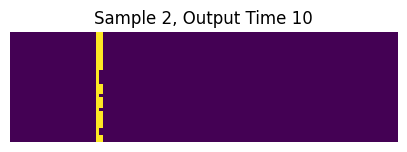

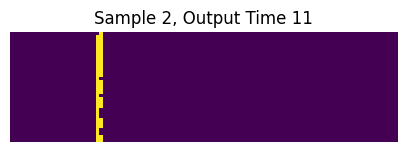

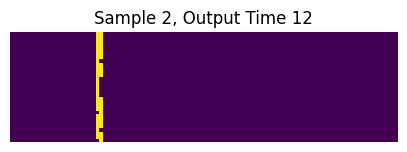

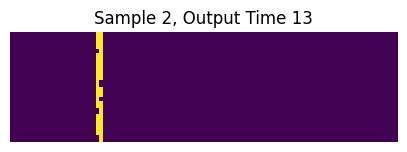

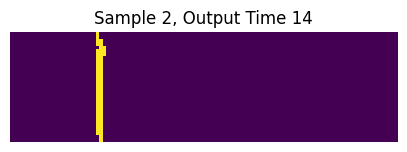

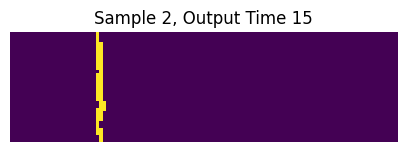

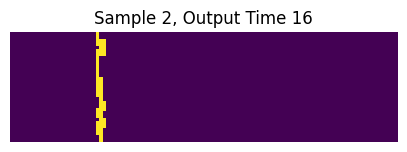

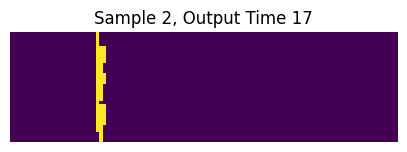

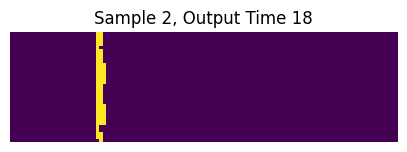

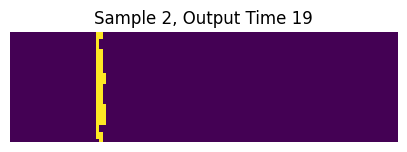

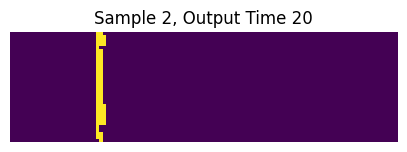

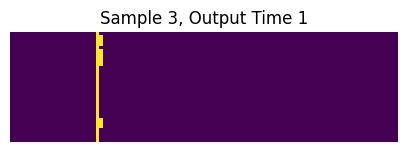

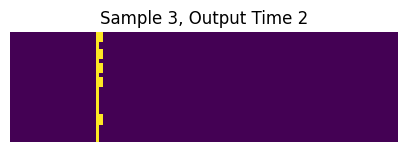

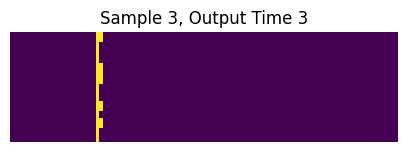

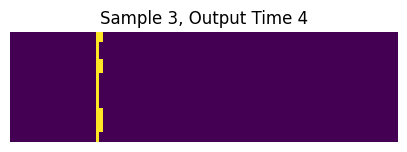

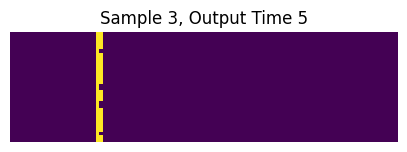

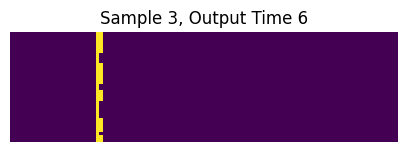

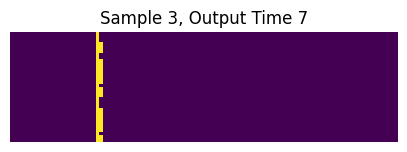

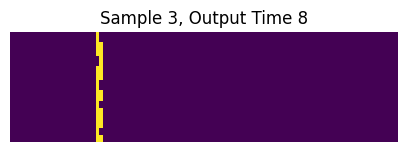

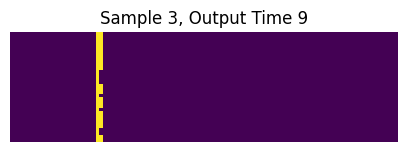

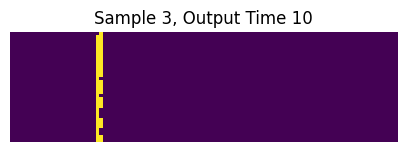

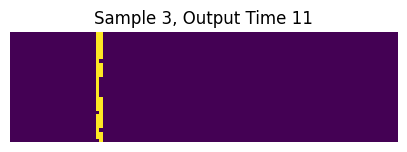

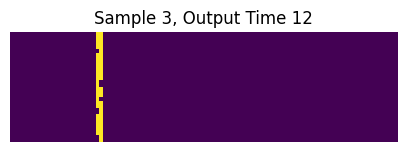

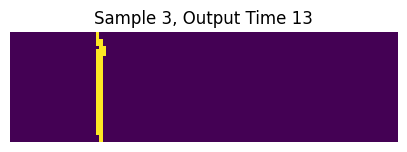

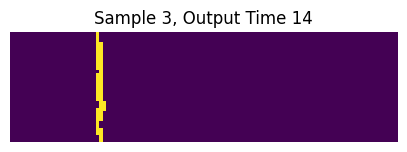

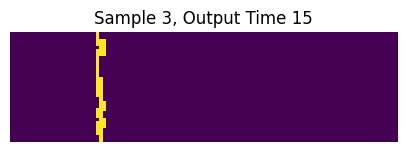

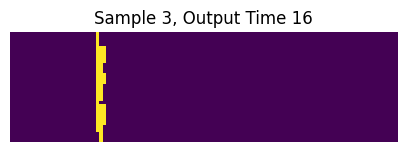

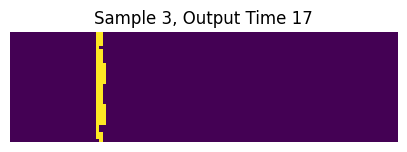

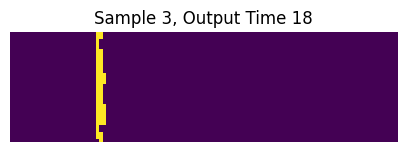

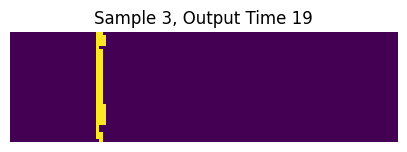

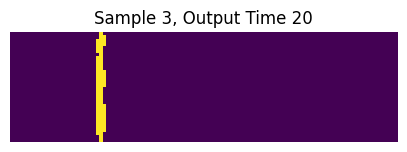

In [ ]:
print("Visualizing training data...")
visualize_data(X_train_sliced, y_train_sliced)

In [ ]:
train_set = FireDataset(X=X_train_sliced, Y=y_train_sliced)
val_set = FireDataset(X=X_val_sliced, Y=y_val_sliced)

In [ ]:
train_sampler = CustomSampler(train_set, BATCH_SIZE)
val_sampler = CustomSampler(val_set, BATCH_SIZE)

dataloader_train = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=4, pin_memory=True)
dataloader_val = DataLoader(val_set, batch_size=BATCH_SIZE, sampler=val_sampler, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print("Setting up the model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EncoderDecoderConvLSTM(input_dim=4, hidden_dim=64, kernel_size=(3, 3), num_layers=3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Setting up the model...


In [ ]:
print("Training the model...")
model = train(model, dataloader_train, dataloader_val, criterion, optimizer, num_epochs=50, device=device, accumulation_steps=4)

Training the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.0168, Val Loss: 0.0082


Epoch 2/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.0087, Val Loss: 0.0080


Epoch 3/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.0082, Val Loss: 0.0070


Epoch 4/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.0062, Val Loss: 0.0060


Epoch 5/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.0049, Val Loss: 0.0051


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783b1554ec20>


Epoch 6/50:   0%|          | 0/110 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 6, Train Loss: 0.0041, Val Loss: 0.0047


Epoch 7/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.0037, Val Loss: 0.0046


Epoch 8/50:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783b1554ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783b1554ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 8, Train Loss: 0.0035, Val Loss: 0.0046


Epoch 9/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.0035, Val Loss: 0.0044


Epoch 10/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.0034, Val Loss: 0.0044


Epoch 11/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.0032, Val Loss: 0.0041


Epoch 12/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.0032, Val Loss: 0.0043


Epoch 13/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.0031, Val Loss: 0.0042


Epoch 14/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.0030, Val Loss: 0.0041


Epoch 15/50:   0%|          | 0/110 [00:40<?, ?it/s]

Epoch 15, Train Loss: 0.0030, Val Loss: 0.0042


Epoch 16/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.0030, Val Loss: 0.0039


Epoch 17/50:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783b1554ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783b1554ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 17, Train Loss: 0.0029, Val Loss: 0.0038


Epoch 18/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.0029, Val Loss: 0.0038


Epoch 19/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.0030, Val Loss: 0.0037


Epoch 20/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.0029, Val Loss: 0.0036


Epoch 21/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 21, Train Loss: 0.0028, Val Loss: 0.0037


Epoch 22/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 22, Train Loss: 0.0029, Val Loss: 0.0036


Epoch 23/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 23, Train Loss: 0.0029, Val Loss: 0.0036


Epoch 24/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 24, Train Loss: 0.0029, Val Loss: 0.0036


Epoch 25/50:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783b1554ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783b1554ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 25, Train Loss: 0.0028, Val Loss: 0.0034


Epoch 26/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 26, Train Loss: 0.0028, Val Loss: 0.0034


Epoch 27/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 27, Train Loss: 0.0027, Val Loss: 0.0038


Epoch 28/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 28, Train Loss: 0.0028, Val Loss: 0.0034


Epoch 29/50:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783b1554ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783b1554ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 29, Train Loss: 0.0027, Val Loss: 0.0036


Epoch 30/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 30, Train Loss: 0.0027, Val Loss: 0.0033


Epoch 31/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 31, Train Loss: 0.0027, Val Loss: 0.0034


Epoch 32/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 32, Train Loss: 0.0027, Val Loss: 0.0034


Epoch 33/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 33, Train Loss: 0.0027, Val Loss: 0.0031


Epoch 34/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 34, Train Loss: 0.0026, Val Loss: 0.0032


Epoch 35/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 35, Train Loss: 0.0026, Val Loss: 0.0033


Epoch 36/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 36, Train Loss: 0.0027, Val Loss: 0.0033


Epoch 37/50:   0%|          | 0/110 [00:20<?, ?it/s]

Epoch 37, Train Loss: 0.0026, Val Loss: 0.0033


Epoch 38/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 38, Train Loss: 0.0026, Val Loss: 0.0032


Epoch 39/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 39, Train Loss: 0.0026, Val Loss: 0.0034


Epoch 40/50:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783b1554ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783b1554ec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 40, Train Loss: 0.0026, Val Loss: 0.0032


Epoch 41/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 41, Train Loss: 0.0026, Val Loss: 0.0034


Epoch 42/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 42, Train Loss: 0.0026, Val Loss: 0.0034


Epoch 43/50:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783b1554ec20>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x783b1554ec20>Exception ignored in: 
    <function _MultiProcessingDataLoaderIter.__del__ at 0x783b1554ec20>Traceback (most recent call last):
self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
          File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    if w.is_alive():Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x783b1554ec20>
self._shutdown_workers()  File "

Epoch 43, Train Loss: 0.0026, Val Loss: 0.0035


Epoch 44/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 44, Train Loss: 0.0026, Val Loss: 0.0037


Epoch 45/50:   0%|          | 0/110 [00:00<?, ?it/s]

In [ ]:
print("Preparing test data...")
X_test = preprocess_data(test_df, is_train=False)
test_set = FireDataset(X=X_test)
dataloader_test = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [ ]:
print("Making predictions...")
model.eval()
predictions = []
with torch.no_grad():
    for batch in tqdm(dataloader_test):
        inputs = batch.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())

In [ ]:
pred = np.concatenate(predictions, axis=0)
pred = pred[:, :, 0, :113, :].clip(0, 1)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [ ]:
y_true = y_val_sliced[:,:,0,:113,:].flatten()

print("Validation MSE :",mean_squared_error(pred,y_true))

In [ ]:
print("Visualizing predictions...")
visualize_data(X_test[:, :, :, :113, :], pred)

In [ ]:
print("Preparing submission...")
y_preds = {}
ids = []
for i, row in test_df.iterrows():
    id = row['id']
    y_preds[id] = np.array(pred[i, :, ...]).flatten(order='C').astype(np.float32)
    ids.append(id)

In [ ]:
df = pd.DataFrame.from_dict(y_preds, orient='index')
df['id'] = ids
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols].reset_index(drop=True)

In [ ]:
df.to_csv('./submission.csv', index=False)
print("Submission file created successfully!")